In [13]:
from loguru import logger
from torchtext.data import get_tokenizer
import torch
import numpy as np
from fcmeans import FCM
from matplotlib import pyplot as plt
from tokenizers import Tokenizer
from tokenizers.models import BPE,WordPiece,Unigram
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer,WordPieceTrainer, UnigramTrainer

In [14]:
class Options:
    def __init__(self, name) -> None:
        self.name= name
    def name(self):
        return self.name

# project gloal parameter
options = Options("Model")
options.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
options.base_path="/home/yang/github/fuzzys2s/"
options.model_parameter_path = options.base_path+"output/"
options.seed_id = 10
options.SOS = 0 # start of sentence
options.EOS = 1 # End of sentence
options.PAD = 2 # padding token
options.UNK = 3 # unknown token, word frequency low
options.src_high_word_freq_percent = 0.025 # min
options.src_low_word_freq_percent = 0.8 # max
options.tgt_high_word_freq_percent = 0.012 # min
options.tgt_low_word_freq_percent = 0.91 # max
options.sentence_feature_num = 2 # [HWF,MWF,LWF]
options.epoch=100
options.feature_num = options.sentence_feature_num
options.rule_num = 12
options.cluster_num = options.rule_num
options.h = 10.0
options.drop_out = 0.1
options.learning_rate = 0.0001


In [15]:
# def tokenizer(sentence):
#     tokenizer = get_tokenizer("basic_english")
#     tokens = tokenizer(sentence)
#     return tokens
tokenizer = Tokenizer(Unigram())
tokenizer.pre_tokenizer = Whitespace()
trainer = UnigramTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])
tokenizer.train(files=["./tatoeba/fra.txt"], trainer=trainer)

class Vocab:
    def __init__(self, name):
        self.name = name
        self.word2index = {"<sos>":options.SOS, "<eos>":options.EOS, "<pad>":options.PAD,"<unk>":options.UNK}
        self.word2count = {"<sos>":1, "<eos>":1, "<pad>":1,"<unk>":1}
        self.index2word = {options.SOS: "<sos>", options.EOS: "<eos>", options.PAD:"<pad>",options.UNK: "<unk>"}
        self.n_words = 4  # Count PAD , SOS and EOS
        self.high_word_freq_limit = 0 # min
        self.low_word_freq_limit = 0 # max

    # def orderWordCount(self, high_percent, low_percent):
    #     word_count_list = sorted(self.word2count.items(), key=lambda x:x[1], reverse=True)
    #     hwf_index = int(high_percent * self.n_words)
    #     self.high_word_freq_limit = word_count_list[hwf_index][1]
    #     lwf_index = int((1-low_percent) * self.n_words)
    #     self.low_word_freq_limit = word_count_list[lwf_index][1]
    #     self.word2count = dict(word_count_list)
    #     logger.info("[%s]max  word freq:%d" %(self.name, word_count_list[2][1]))
    #     logger.info("[%s]high word freq:%d, percent:%.2f, index:%d" %(self.name, self.high_word_freq_limit, high_percent*100, hwf_index))
    #     logger.info("[%s]low  word freq:%d, percent:%.2f, index:%d" %(self.name, self.low_word_freq_limit, low_percent*100, lwf_index))

    def addSentence(self, sentence):
        tokens = tokenizer.encode(sentence).tokens
        for word in tokens:
            self.addWord(word)

    def addTokens(self, tokens):
        for word in tokens:
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


In [18]:

def build_vocab(vocab_src, vocab_tgt, tokens):
    for sentence in tokens:
        src = sentence[0]
        tgt = sentence[1]
        vocab_src.addTokens(src)
        vocab_tgt.addTokens(tgt)
        # if len(src) > vocab_src.line_max:
        #     vocab_src.line_max = len(src)
        # if len(tgt) > vocab_tgt.line_max:
        #     vocab_tgt.line_max = len(tgt)
    return vocab_src, vocab_tgt


def gen_token_vectors(vocab_src, vocab_tgt, tokens):
    token_vectors =[]
    for row in tokens:
        src = [vocab_src.word2index[word]  for word in row[0]]
        tgt = [vocab_tgt.word2index[word]  for word in row[1]]
        token_vectors.append([src, tgt])
    return token_vectors


def read_tatoeba_data():
    logger.info("read raw data")
    fd = open(options.base_path+"/doc/tatoeba/fra.txt",encoding = "utf-8")
    lines = fd.readlines()
    logger.info("dataset:tatoeba, total:%d" %(len(lines)))
    tokens = [] #  src-tgt token pairs
    for line in lines:
        sen = line.split('\t')
        src = sen[0] # en
        tgt = sen[1] # fr
        # src = "<sos> " + src + " <eos>"
        # tgt = "<sos> " + tgt + " <eos>"
        src = tokenizer.encode(src).tokens
        tgt = tokenizer.encode(tgt).tokens
        tokens.append([src, tgt])
    fd.close()
    total = len(tokens)
    part = int(total/10)
    train_tokens = tokens[:total - part*2]
    valid_tokens = tokens[total - part*2:total - part]
    test_tokens = tokens[total - part:]
    logger.info("build vocabulary")
    vocab_src = Vocab("src en")
    vocab_tgt = Vocab("tgt fr")
    build_vocab(vocab_src, vocab_tgt, train_tokens)
    build_vocab(vocab_src, vocab_tgt, valid_tokens)
    build_vocab(vocab_src, vocab_tgt, test_tokens)
    # vocab_src.orderWordCount(options.src_high_word_freq_percent, options.src_low_word_freq_percent)
    # vocab_tgt.orderWordCount(options.tgt_high_word_freq_percent, options.tgt_low_word_freq_percent)
    logger.info("src vocab name:%s, size:%d" %(vocab_src.name, vocab_src.n_words))
    logger.info("tgt vocab name:%s, size:%d" %(vocab_tgt.name, vocab_tgt.n_words))
    logger.info("generate token vectors")
    train_data = gen_token_vectors(vocab_src, vocab_tgt, train_tokens)
    valid_data = gen_token_vectors(vocab_src, vocab_tgt, valid_tokens)
    test_data = gen_token_vectors(vocab_src, vocab_tgt, test_tokens)
    return train_data, valid_data, test_data, vocab_src, vocab_tgt

In [19]:
train_data, valid_data, test_data, vocab_src, vocab_tgt = read_tatoeba_data()

2023-04-19 06:03:03.702 | INFO     | __main__:read_tatoeba_data:24 - read raw data
2023-04-19 06:03:03.750 | INFO     | __main__:read_tatoeba_data:27 - dataset:tatoeba, total:217975
2023-04-19 06:03:07.559 | INFO     | __main__:read_tatoeba_data:44 - build vocabulary
2023-04-19 06:03:08.061 | INFO     | __main__:read_tatoeba_data:52 - src vocab name:src en, size:3427
2023-04-19 06:03:08.061 | INFO     | __main__:read_tatoeba_data:53 - tgt vocab name:tgt fr, size:4450
2023-04-19 06:03:08.061 | INFO     | __main__:read_tatoeba_data:54 - generate token vectors


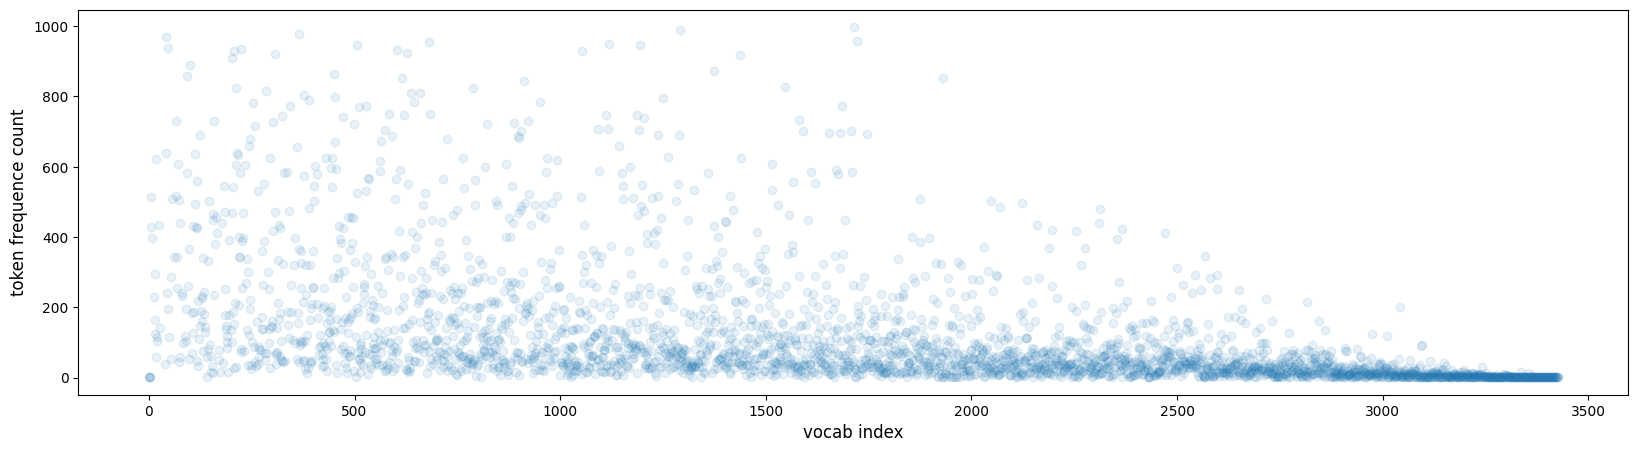

In [25]:
data = []
for i in range(vocab_src.n_words):
    word = vocab_src.index2word[i]
    count = vocab_src.word2count[word]
    if count <1000:
        data.append([i, count])
    
data = np.array(data)

plt.figure(figsize=(20, 5))
plt.xlabel("vocab index", size=12)
plt.ylabel("token frequence count", size=12)
plt.scatter(data[:,0], data[:,1], alpha=.1)
plt.show()

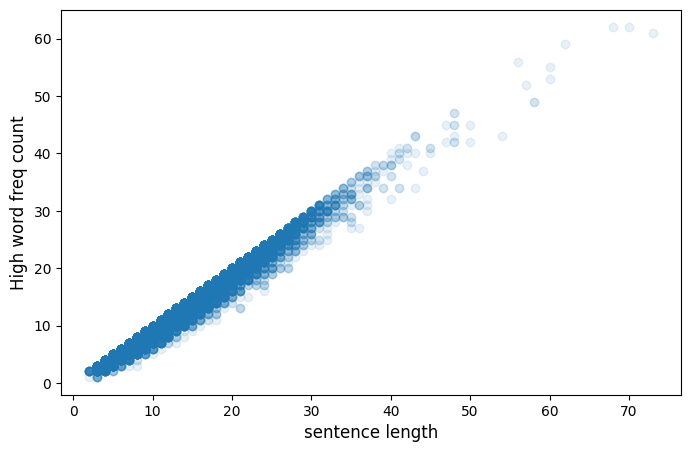

In [22]:
src_sens = []
tgt_sens = []
datset = train_data + valid_data + test_data
for i in range(len(datset)):
    sen = datset[i][0] # src
    slen = len(sen)
    HWF = 0
    LWF = 0
    for index in sen:
        word = vocab_src.index2word[index]
        count = vocab_src.word2count[word]
        if count > 100:
            HWF = HWF + 1
        elif count < 5:
            LWF = LWF + 1
    src_sens.append([slen,HWF])

    sen = datset[i][1] # tgt
    slen = len(sen)
    HWF = 0
    LWF = 0
    for index in sen:
        word = vocab_tgt.index2word[index]
        count = vocab_tgt.word2count[word]
        if count > 20:
            HWF = HWF + 1
        elif count < 5:
            LWF = LWF + 1
    tgt_sens.append([slen,HWF])
    
sens = np.array(src_sens)

plt.figure(figsize=(8, 5))
plt.scatter(sens[:,0], sens[:,1], alpha=.1)
plt.xlabel("sentence length", size=12)
plt.ylabel("High word freq count", size=12)
plt.show()

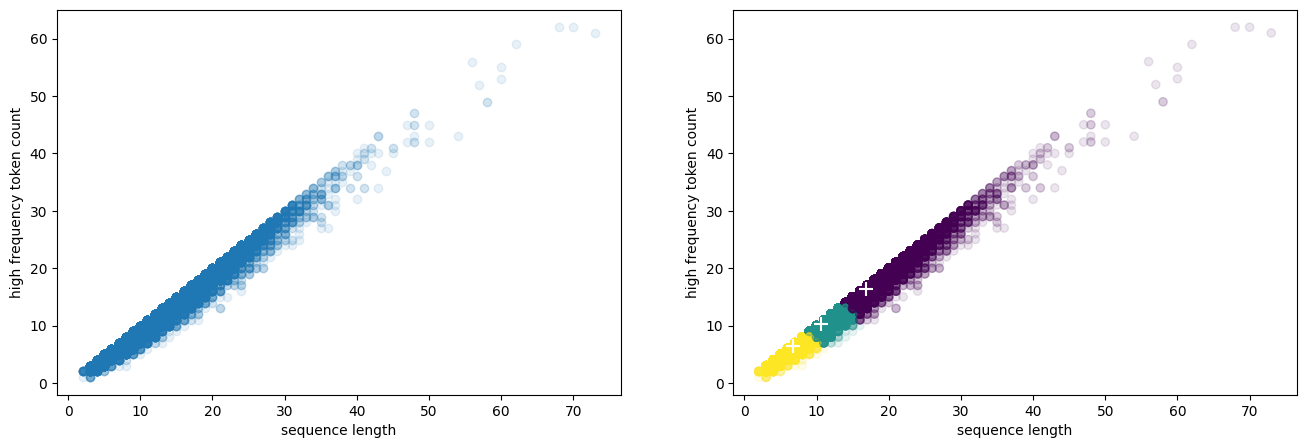

In [26]:
X = np.array(src_sens)
fcm = FCM(n_clusters=3)
fcm.fit(X)
# outputs
fcm_centers = fcm.centers
fcm_labels = fcm.predict(X)

# plot result
f, axes = plt.subplots(1, 2, figsize=(16,5))

for i, row in enumerate(axes):
    row.set_xlabel("sequence length")
    row.set_ylabel("high frequency token count")
axes[0].scatter(X[:,0], X[:,1], alpha=.1)
axes[1].scatter(X[:,0], X[:,1], c=fcm_labels, alpha=.1)
axes[1].scatter(fcm_centers[:,0], fcm_centers[:,1], marker="+", s=100, c='w')
plt.show()

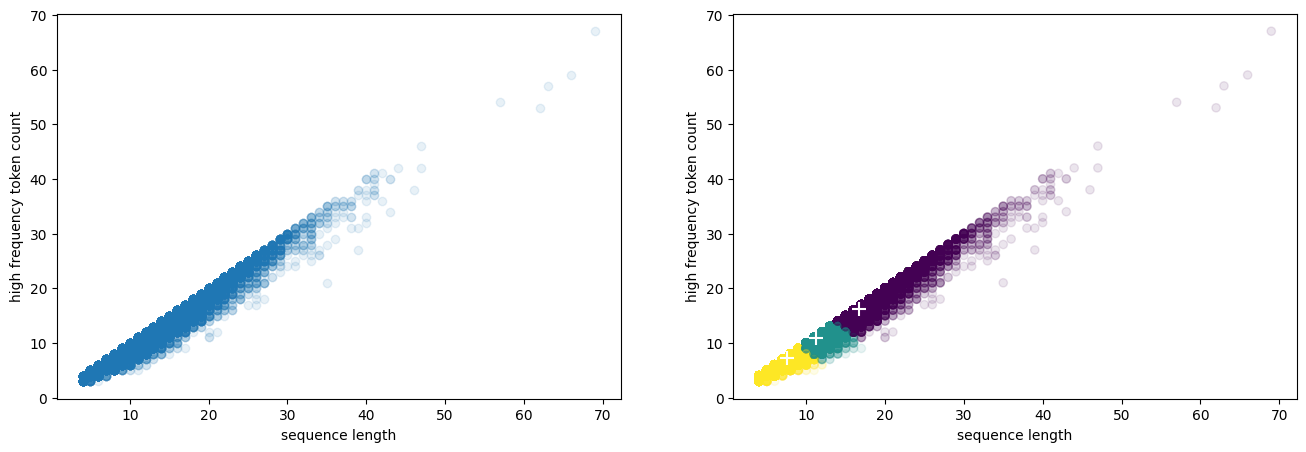

In [120]:
X = np.array(tgt_sens)
fcm = FCM(n_clusters=3)
fcm.fit(X)
# outputs
fcm_centers = fcm.centers
fcm_labels = fcm.predict(X)

# plot result
f, axes = plt.subplots(1, 2, figsize=(16,5))

for i, row in enumerate(axes):
    row.set_xlabel("sequence length")
    row.set_ylabel("high frequency token count")
axes[0].scatter(X[:,0], X[:,1], alpha=.1)
axes[1].scatter(X[:,0], X[:,1], c=fcm_labels, alpha=.1)
axes[1].scatter(fcm_centers[:,0], fcm_centers[:,1], marker="+", s=100, c='w')
plt.show()